Using 
- sdpa 
- optimizer
- compile 
- more data
- MixedPrecision()
- lr_sched
- Double layer norm
- Using a custom tokenizer.
- GLU
- sdpa linear
- modern bert sequence packing + FA2

# Tiny Stories Hackathon
> From Cluster of stars study group

## Data

### Dataset 

In [ ]:
from datasets import load_dataset
import torch
import math
import torch.nn as nn
import torch.nn.functional as F
from torch import Tensor, BoolTensor

from minai import *

Grab tiny stories data from hugging face.

In [ ]:
ds = load_dataset('roneneldan/TinyStories')
trn = ds['train']
val = ds['validation']
trn

Dataset({
    features: ['text'],
    num_rows: 2119719
})

In [ ]:
val

Dataset({
    features: ['text'],
    num_rows: 21990
})

In [ ]:
from minbpe import RegexTokenizer
from fastcore.all import *

In [ ]:
path = Path.home()/'git/minai/TinyStories_All_data'

In [ ]:
tokenizer = RegexTokenizer()
# tokenizer.train(txt_raw, vocab_size=3000)

tokenizer.load((path/"tok3k_regex.model").name) # loads the model back from disk
tokenizer.encode("hello world") # string -> tokens

[257, 2365, 1597]

In [ ]:
txt = trn[0]['text']
txt

'One day, a little girl named Lily found a needle in her room. She knew it was difficult to play with it because it was sharp. Lily wanted to share the needle with her mom, so she could sew a button on her shirt.\n\nLily went to her mom and said, "Mom, I found this needle. Can you share it with me and sew my shirt?" Her mom smiled and said, "Yes, Lily, we can share the needle and fix your shirt."\n\nTogether, they shared the needle and sewed the button on Lily\'s shirt. It was not difficult for them because they were sharing and helping each other. After they finished, Lily thanked her mom for sharing the needle and fixing her shirt. They both felt happy because they had shared and worked together.'

In [ ]:
def txt_to_toks(txt, toker): return toker.encode(txt)

In [ ]:
def toks_to_txt(toks, toker): return toker.decode(toks)

In [ ]:
num_txts = 10
num_txts

10

In [ ]:
separator="\n\n\n"
ctx_len = 1024

We create a dataset.

In [ ]:
def transforms(b):
    d = {}
    d['input_ids'] = [tokenizer.encode(t, allowed_special={"<|endoftext|>"}) for t in b['text']]
    return d

In [ ]:
def batched(iterable, n):
    # batched('ABCDEFG', 3) → ABC DEF G
    if n < 1:
        raise ValueError("n must be at least one")
    iterator = iter(iterable)
    while batch := list(itertools.islice(iterator, n)):
        yield batch

In [ ]:
tds = ds.with_transform(transforms)
tds['train'][0]['input_ids'][:10]

[516, 327, 44, 258, 390, 479, 402, 406, 507, 258]

In [ ]:
tds['train']

Dataset({
    features: ['text'],
    num_rows: 2119719
})

In [ ]:
bs = 4
next(batched(tds['train'].select(range(50)), bs))

[{'input_ids': [516,
   327,
   44,
   258,
   390,
   479,
   402,
   406,
   507,
   258,
   775,
   302,
   313,
   338,
   720,
   46,
   342,
   677,
   309,
   282,
   2876,
   265,
   325,
   328,
   309,
   708,
   309,
   282,
   2073,
   46,
   406,
   407,
   265,
   850,
   261,
   775,
   302,
   328,
   338,
   386,
   44,
   391,
   392,
   468,
   459,
   119,
   258,
   1674,
   354,
   338,
   2377,
   304,
   10,
   670,
   426,
   265,
   338,
   386,
   266,
   323,
   44,
   317,
   844,
   44,
   337,
   507,
   733,
   775,
   302,
   46,
   1127,
   349,
   850,
   309,
   328,
   524,
   266,
   459,
   119,
   627,
   2377,
   476,
   937,
   386,
   565,
   266,
   323,
   44,
   317,
   732,
   44,
   406,
   44,
   363,
   469,
   850,
   261,
   775,
   302,
   266,
   1125,
   629,
   2377,
   505,
   10,
   2826,
   44,
   360,
   1208,
   261,
   775,
   302,
   266,
   459,
   119,
   263,
   261,
   1674,
   354,
   406,
   384,
   2377,
   46,
   42

In [ ]:
input_batches = list(batched(tds['train'].select(range(100)), bs))
len(input_batches)

25

In [ ]:
input_batches[:2]

[[{'input_ids': [516,
    327,
    44,
    258,
    390,
    479,
    402,
    406,
    507,
    258,
    775,
    302,
    313,
    338,
    720,
    46,
    342,
    677,
    309,
    282,
    2876,
    265,
    325,
    328,
    309,
    708,
    309,
    282,
    2073,
    46,
    406,
    407,
    265,
    850,
    261,
    775,
    302,
    328,
    338,
    386,
    44,
    391,
    392,
    468,
    459,
    119,
    258,
    1674,
    354,
    338,
    2377,
    304,
    10,
    670,
    426,
    265,
    338,
    386,
    266,
    323,
    44,
    317,
    844,
    44,
    337,
    507,
    733,
    775,
    302,
    46,
    1127,
    349,
    850,
    309,
    328,
    524,
    266,
    459,
    119,
    627,
    2377,
    476,
    937,
    386,
    565,
    266,
    323,
    44,
    317,
    732,
    44,
    406,
    44,
    363,
    469,
    850,
    261,
    775,
    302,
    266,
    1125,
    629,
    2377,
    505,
    10,
    2826,
    44,
    360,
    1208,
    261,


### Sequence packer

In [ ]:
# Copyright 2024 onwards Answer.AI, LightOn, and contributors
# License: Apache-2.0

import threading
import time
from abc import ABC, abstractmethod
from collections import deque
from typing import Generic, Iterable, NamedTuple, Optional, TypeVar, Any, Union, Sequence
from composer.core.types import Batch

import numpy as np
import torch
from numba import njit


import math
from composer.core import Time


class BatchSizeWarmupScheduler:
    def __init__(
        self,
        min_batch_size: int,
        max_batch_size: int,
        warmup_tokens: Union[str, Time, int],
        world_size: int,
    ):
        self.min_batch_size = min_batch_size
        self.max_batch_size = max_batch_size

        if isinstance(warmup_tokens, str):
            self.warmup_tokens = Time.from_timestring(warmup_tokens).value
        elif isinstance(warmup_tokens, Time):
            self.warmup_tokens = warmup_tokens.value
        else:
            self.warmup_tokens = warmup_tokens
        self.warmup_tokens = math.ceil(self.warmup_tokens / world_size)
        self._step_thresholds = self._calculate_step_thresholds()

    def _calculate_step_thresholds(self):
        total_batch_sizes = sum(range(self.min_batch_size, self.max_batch_size))
        steps_per_unit = self.warmup_tokens / total_batch_sizes

        thresholds = []
        cumsum = 0
        for batch_size in range(self.min_batch_size, self.max_batch_size):
            cumsum += batch_size
            steps = math.ceil(steps_per_unit * cumsum)
            thresholds.append(steps)
        return thresholds

    def __call__(self, current_step: int) -> int:
        if current_step >= self.warmup_tokens:
            return self.max_batch_size

        for i, threshold in enumerate(self._step_thresholds):
            if current_step < threshold:
                return self.min_batch_size + i

        # should never hit this, but just in case
        return self.max_batch_size


class SequencePackerBatchOutputTuple(NamedTuple):
    masked_pseqs: torch.Tensor
    labels: Optional[torch.Tensor]
    cu_seq_lens: list[torch.Tensor]
    max_cu_seq_len: list[torch.Tensor]


class SequencePacker(ABC):
    def __init__(
        self,
        # params defining the incoming batches of seqs
        src_iterable: Iterable[list[list[int]]],
        src_batch_size: int,
        src_max_seq_len: int,
        # params defining outgoing batches of pseqs
        out_batch_size: int,
        out_pseq_len: int,
        # params defining internal behavior
        buffer_size: int,
        pad_token_id: int = -1,
        mask_token_id: int = 0,
        ignore_token_id: int = -100,
        mask_prob: float = 0.3,
        seed=42,
        suppress_masking: bool = False,
        batch_size_warmup_min_size: Optional[int] = None,
        batch_size_warmup_tokens: Optional[Union[str, Time]] = None,
        world_size: int = 1,
    ):
        """
        Takes batches of unpacked, unpadded sequences (seqs) to batches of packed and padded sequences (pseqs).

        Every input batch must be a list[list[int]], a list of variable-length sequences of tokens.

        Every output batch is a tuple (masked_inputs:Tensor, labels:Tensor, seq_starts_and_end:list).

        It performs this streamwise, taking an iterable as the source of incoming batches, and
        presents itself as an iterable of outgoing batches.

        Args:
            src_iterable: An iterable (e.g., a DataLoader), whose iterator yields one incoming batch,
                        where a batch is a list of unpadded, variable-length Sequences of token
                        IDs. Since this only needs to be an Iterable, it could also be a generator object
                         like the result of `itertools.batched(dataset_list,batch_size))`

            src_batch_size:  This is the INCOMING batch size, the number of seqs in one batch yielded
                          from `src_iterable`'s iterator.

            src_max_seq_len: The maximum number of tokens in a seq within an incoming batch.

            out_batch_size: the number of pseqs (packed seqs) in one outgoing batch

            out_pseq_len: the number of tokens per packed seq, in every outgoing batch

            buffer_size: The maximum number of seqs which may be buffered internally.

            pad_token_id: The token ID used for padding the space which cannot be filled to reach out_pseq_len.

            mask_token_id: The token ID used for masking tokens in the input sequence.

            ignore_token_id: The token ID used to ignore tokens. Expected to be applied to every non-masked token, so the model only trains on predictions of masked tokens.

            suppress_masking: If True, the sequence packer will not perform masked language modeling.

            batch_size_warmup_min_size: If not None, the sequence packer will gradually increase the batch size from batch_size_warmup_min_size to out_batch_size over the course of the warmup_tokens.
                                    batch_size_warmup_min_size must be a multiple of micro_batch_size.

            batch_size_warmup_tokens: If not None, the sequence packer will gradually increase the batch size from batch_size_warmup_min_size to out_batch_size over the course of the warmup_tokens.

            world_size: The number of processes participating in this training run. batch_size_warmup_min_size is divided by this number.
        """
        assert buffer_size >= out_batch_size, f"required that {buffer_size=} >= {out_batch_size=}"
        self.src_dataloader_len = len(src_iterable)
        self.src_iterable = src_iterable
        self.src_batch_size = src_batch_size
        self.out_batch_size = out_batch_size
        self.out_pseq_len = out_pseq_len
        self.buffer_size = buffer_size
        self.pad_token_id = pad_token_id
        self.mask_token_id = mask_token_id
        self.ignore_token_id = ignore_token_id
        self.mask_prob = mask_prob
        self.suppress_masking = suppress_masking
        # internals
        self.buffer = deque()  # internal buffer holds individual seqs, as tensors.
        # for stats to report packing efficiency.
        self._seqs_consumed = 0
        self._seqs_emitted = 0
        # Set random seed
        self.seed = seed
        self.epoch = -1
        self._token_count = 0
        self.batch_size_scheduler = None
        if batch_size_warmup_min_size is not None and batch_size_warmup_tokens is not None:
            self.batch_size_scheduler = BatchSizeWarmupScheduler(
                batch_size_warmup_min_size, out_batch_size, batch_size_warmup_tokens, world_size
            )
        else:
            self.batch_size_scheduler = None

    @property
    def seqs_emitted(self):
        "Number of seqs, incoming from src_iterable, which have been emitted in OUTGOING batches."
        return self._seqs_emitted

    @property
    def seqs_consumed(self):
        "Number of seqs, incoming from src_iterable, which have been consumed."
        return self._seqs_consumed

    def _reset_state(self):
        self.epoch += 1
        self.buffer.clear()
        self._seqs_consumed = 0
        self._seqs_emitted = 0
        self.np_rng = np.random.default_rng(self.epoch + self.seed)

        # Update the epoch for the sampler
        if isinstance(self.src_iterable, torch.utils.data.dataloader.DataLoader):
            if isinstance(self.src_iterable.sampler, torch.utils.data.distributed.DistributedSampler):
                self.src_iterable.sampler.set_epoch(self.epoch)

    def __iter__(self):
        self._reset_state()
        self.src_iterator = iter(self.src_iterable)
        return self._generate_batches()

    def __len__(self):
        # rather than estimate the packed length of the dataset, we rely on Composer's ability
        # to schedule training the using the number of batches or tokens instead of epochs.
        return None

    def _fill_buffer(self, max_items_to_add=float("inf")) -> int:
        """
        Refills the internal buffer.

        - max_items_to_add: an amount less than or equal to the number of items to add

        Returns: the number of items actually added.

        The default implementation of this simply extends to src.buffer, which is
        initialized as a list in __init__. Subclasses which want to use a different data
        structure for internal buffering should override this method and also add
        code in __init__ to initialize src.buffer appropriately.

        Any implementation of this MUST never place more than self.buffer_size items
        in the internal buffer.
        """
        items_added = 0
        # NOTE: this should be >=, kept as is to match model training code
        # TODO: change if training a new model
        while (self.buffer_size - len(self.buffer)) > self.src_batch_size:
            try:
                # if pulling another batch would fetch more than the requested max, stop
                if max_items_to_add < float("inf"):
                    if (items_added + self.src_batch_size) > max_items_to_add:
                        # print("Not adding, because of max_items_to_fetch")
                        break
                incoming_batch = next(self.src_iterator)
                assert (
                    len(incoming_batch) <= self.src_batch_size
                ), f"expected {len(incoming_batch)=} <= {self.src_batch_size=}"
                for item in incoming_batch:
                    if len(item["input_ids"]) > 0:  # ignore empty sequences
                        self.buffer.append(item["input_ids"])
                        items_added += 1
                        self._seqs_consumed += 1
            except StopIteration:
                break
        return items_added

    def _generate_batches(self):
        """
        Generates batches of packed sequences.

        The returned generator's iterator will always, when next() is called on it, either:
         - return a valid tuple batch (masked_batch, labels, cu_seq_lens,max_seq_lens)
         - raise StopIteration
        """
        while True:
            retval = self._create_batch()
            if retval is None:
                break
            batch, lst_cu_seq_lens = retval

            assert isinstance(retval, tuple), f"Unexpected {type(retval)=}"
            assert isinstance(retval[0], np.ndarray), f"Unexpected {type(retval[0])=}"
            assert isinstance(retval[1], list), f"Unexpected {type(retval[1])=}"

            cu_seq_lens = [torch.tensor(x, dtype=torch.int32) for x in lst_cu_seq_lens]
            max_seq_lens = [torch.max(x[1:] - x[:-1]).item() for x in cu_seq_lens]
            assert isinstance(cu_seq_lens, list), f"Unexpected {type(cu_seq_lens)=}"
            if self.suppress_masking:
                yieldval = {
                    "input_ids": torch.from_numpy(batch),
                    "labels": None,
                    "cu_seqlens": cu_seq_lens,
                    "max_seqlen": max_seq_lens,
                }
            else:
                (masked_batch, labels) = SequencePacker.mlm_masking(
                    batch, self.mask_prob, self.mask_token_id, self.pad_token_id, self.ignore_token_id, self.np_rng
                )
                yieldval = {
                    "input_ids": torch.from_numpy(masked_batch),
                    "labels": torch.from_numpy(labels),
                    "cu_seqlens": cu_seq_lens,
                    "max_seqlen": max_seq_lens,
                    "attention_mask": torch.from_numpy(np.where(batch == self.pad_token_id, 0, 1)),
                }
                self._token_count += yieldval["attention_mask"].sum().item()
            # # assert isinstance(yieldval[0], torch.Tensor), f"Unexpected {type(yieldval[0])=}"
            # if not self.suppress_masking:
            #     assert isinstance(yieldval[1], torch.Tensor), f"Unexpected {type(yieldval[1])=}"
            # assert isinstance(yieldval[2], list), f"Unexpected {type(yieldval[2])=}"
            # if yieldval[2]:
            #     assert isinstance(yieldval[2][0], torch.Tensor), f"Unexpected {type(yieldval[2][0])=}"
            yield yieldval

    @staticmethod
    def mlm_masking(
        seq: np.ndarray,
        mask_prob: float,
        mask_token: int,
        pad_token: int = -1,
        ignore_index: int = -100,
        np_rng=np.random.default_rng(),
    ) -> tuple[np.ndarray, np.ndarray]:
        """
        Prepare masked tokens inputs/labels for masked language modeling: 80% MASK, 10% random, 10% original.

        This is exactly a numpy version of transformers' `DataCollatorForLanguageModeling.torch_mask_tokens`
        https://github.com/huggingface/transformers/blob/main/src/transformers/data/data_collator.py#L827

        It performs masking in a way that produces on expectation the following masked inputs:
         - (1-mask_prob) of the original positions will be untouched.
         - mask_prob * 80%  of the original positions get replaced with a mask token
         - mask_prob * 10%  of the original positions get replaced with a random token
         - mask_prob * 10%  of the original positions also remain untouched.
        This generates the masked_inputs.

        It also generates a labels array, which has ignore tokens in the (1-mask_prob) positions

        These proportions are expectation values since the random transformation is performed
        independently per element. (This is why it is agnostic wrt shape.)

        Args:
          seq (np.ndarray): the input token IDs (e.g., a sequence, or batch of seqs)
          mask_prob (float): probability of initially masking a token, in the first "wave" of masking
          mask_token (int): token to use for masking
          ignore_index (int): the token indicating that position should be ignored during training. We call it `ignore_index` to conform to the API of the cross entropy loss function.

        Returns:
            tuple[np.array,np.array]: (masked_seq, labels)
                masked_seq: the input seq with some tokens replaced by `mask_token`
                labels: the original input seq with non-masked tokens replaced by `ignore_index`
        """
        # Create labels
        labels = np.where(seq == pad_token, ignore_index, seq)

        # Create a single mask
        rand = np_rng.random(seq.shape)

        # Partition the probability space appropriately using a single mask
        # 80% of the time, we mask the token
        mask_mask = rand < mask_prob * 0.8
        # 10% of the time, we replace the token with a random token
        random_mask = (rand >= mask_prob * 0.8) & (rand < mask_prob * 0.9)
        # 10% of the time, we keep the token the same
        keep_mask = (rand >= mask_prob * 0.9) & (rand < mask_prob)

        # We only compute loss over the tokens marked for masking
        labels = np.where(mask_mask | random_mask | keep_mask, labels, ignore_index)

        # Apply masking
        seq = np.where(mask_mask, mask_token, seq)

        # Apply random replacement
        random_words = np_rng.integers(0, np.max(seq) + 1, size=seq.shape)
        seq = np.where(random_mask, random_words, seq)

        return seq, labels

    @abstractmethod
    def _create_batch(self) -> Optional[tuple[np.ndarray, list[list[int]]]]:
        """
        Returns a batch of packed sequences with its cumulative seq length information.

        Or else, returns None if it cannot build a full outgoing batch.

        Must mutate self.buffer to remove the sequences that are packed into the batch.

        Returns:
            (out_batch,cumulative_seq_len):tuple[torch.tensor, list[list[int]]]
            where:
                - out_batch is a tensor of shape (out_batch_size, out_pseq_len);
                - cum_seq_lens is a list of lists, where the outer list is of len out_batch_size,
                    and each inner list is of varying length, and contains the start positions of
                    every seq in the pseq, and the end position of the last seq in the pseq. This end
                    position is necessary to communicate if any padding tokens were added.
        """
        pass


@njit
def find_best_fit(remaining_spaces, seq_len):
    valid_spaces = seq_len <= remaining_spaces
    if np.any(valid_spaces):
        valid_space_sizes = remaining_spaces[valid_spaces]
        best_fit_idx = np.argmin(valid_space_sizes)
        return np.arange(len(remaining_spaces))[valid_spaces][best_fit_idx]
    return -1


class GreedyBestFitSequencePacker(SequencePacker):
    @classmethod
    def from_composer(
        cls,
        src_iterable: Iterable[list[list[int]]],
        batch_size: int = 512,
        micro_batch_size: int = 32,
        max_seq_len: int = 1024,
        buffer_size: int = 5120,
        # token values
        pad_token_id: int = -1,
        mask_token_id: int = 0,
        ignore_token_id: int = -100,
        mask_prob: float = 0.3,
        # transform values
        seed=42,
        suppress_masking=False,
        batch_size_warmup_min_size: Optional[int] = None,
        batch_size_warmup_tokens: Optional[Union[str, Time]] = None,
        world_size: int = 1,
    ) -> "GreedyBestFitSequencePacker":
        if batch_size_warmup_min_size is not None:
            if batch_size_warmup_min_size % micro_batch_size != 0:
                raise ValueError(f"{batch_size_warmup_min_size=} must be a multiple of {micro_batch_size=}")
            batch_size_warmup_min_size = int(batch_size_warmup_min_size / micro_batch_size)
        return cls(
            # input shape
            src_iterable=src_iterable,
            src_batch_size=batch_size,
            src_max_seq_len=max_seq_len,
            # output shape
            out_batch_size=int(batch_size / micro_batch_size),
            out_pseq_len=int(micro_batch_size * max_seq_len),
            # internal
            buffer_size=buffer_size,
            # transformation
            pad_token_id=pad_token_id,
            mask_token_id=mask_token_id,
            ignore_token_id=ignore_token_id,
            mask_prob=mask_prob,
            seed=seed,
            suppress_masking=suppress_masking,
            batch_size_warmup_min_size=batch_size_warmup_min_size,
            batch_size_warmup_tokens=batch_size_warmup_tokens,
            world_size=world_size,
        )

    def _create_batch(self) -> Optional[tuple[np.ndarray, list[list[int]]]]:
        if self.batch_size_scheduler:
            self.out_batch_size = self.batch_size_scheduler(self._token_count)

        batch = np.full(
            (self.out_batch_size, self.out_pseq_len), self.pad_token_id, dtype=np.int64
        )  # the pseqs being constructed
        seq_counts = np.zeros(self.out_batch_size, dtype=np.int32)  # the count of seqs per pseq
        cum_seq_lens = [[0] for _ in range(self.out_batch_size)]
        remaining_spaces = np.full(
            (self.out_batch_size,), self.out_pseq_len, dtype=np.int32
        )  # the space remaining per pseq
        temp_buffer = []

        while True:
            # Check if buffer has more items, and if not replenish
            if not self.buffer:
                items_to_fetch = self.buffer_size - len(temp_buffer)
                items_added = self._fill_buffer(items_to_fetch)
                if items_added == 0:
                    break

            seq = self.buffer.popleft()
            seq_len = len(seq)

            # Find the best fit (smallest space that can accommodate the sequence)
            best_fit_idx = find_best_fit(remaining_spaces, seq_len)
            if best_fit_idx != -1:
                end_pos = self.out_pseq_len - remaining_spaces[best_fit_idx]
                batch[best_fit_idx, end_pos : end_pos + seq_len] = seq
                seq_counts[best_fit_idx] += 1
                remaining_spaces[best_fit_idx] -= seq_len
                cum_seq_lens[best_fit_idx].append(cum_seq_lens[best_fit_idx][-1] + seq_len)
            else:
                # Can't fit the sequence, save for next batch
                temp_buffer.append(seq)

        # Add any sequences we skipped back to the start of the buffer
        self.buffer.extendleft(temp_buffer)
        if np.all(seq_counts > 0):
            self._seqs_emitted += np.sum(seq_counts)
            for x in cum_seq_lens:
                if x[-1] != self.out_pseq_len:
                    x.append(self.out_pseq_len)
            return batch, cum_seq_lens
        else:
            # If we can't form a full batch, we return None to signal the end
            return None


T = TypeVar("T")


class BufferedIterable(Generic[T]):
    def __init__(self, iterable: Iterable[T], buffer_size: int):
        """
        Args:
          - iterable: an object which generates a fresh iterator on iter() and which implements len()
        """
        self.iterable = iterable
        self.buffer_size = buffer_size

    def __iter__(self):
        return BufferedIterator(self.iterable, self.buffer_size)


class BufferedIterator(Generic[T]):
    def __init__(self, iterable: Iterable[T], buffer_size: int):
        self.iterator = iter(iterable)
        self.buffer = deque(maxlen=buffer_size)
        self.buffer_size = buffer_size
        self.lock = threading.Lock()
        self.exhausted = False
        self.filler_thread = threading.Thread(target=self._background_fill, daemon=True)
        self.filler_thread.start()

    def _background_fill(self):
        # Fill up the buffer, whenever possible, in the background
        while not self.exhausted:
            if len(self.buffer) < self.buffer_size:
                try:
                    item = next(self.iterator)
                    with self.lock:
                        self.buffer.append(item)
                except StopIteration:
                    self.exhausted = True
                    break
            else:
                time.sleep(0.01)  # Sleep for a bit to avoid busy waiting

    def __iter__(self):
        return self

    def __next__(self) -> T:
        while True:
            if not self.buffer:
                if self.exhausted:
                    # We've exhausted the iterator and the buffer so we're done
                    raise StopIteration
                else:
                    # The buffer is empty but the iterator is not exhausted yet.
                    # Let's give the filler thread a chance to add items to the buffer
                    time.sleep(0.01)
            else:
                with self.lock:
                    return self.buffer.popleft()

In [ ]:
class CausalSequencePacker(GreedyBestFitSequencePacker):
    def _generate_batches(self):
        """
        Generates batches of packed sequences for causal attention.
        """
        while True:
            retval = self._create_batch()
            if retval is None:
                break
            batch, lst_cu_seq_lens = retval

            assert isinstance(retval, tuple), f"Unexpected {type(retval)=}"
            assert isinstance(retval[0], np.ndarray), f"Unexpected {type(retval[0])=}"
            assert isinstance(retval[1], list), f"Unexpected {type(retval[1])=}"

            cu_seq_lens = [torch.tensor(x, dtype=torch.int32) for x in lst_cu_seq_lens]
            max_seq_lens = [torch.max(x[1:] - x[:-1]).item() for x in cu_seq_lens]
            assert isinstance(cu_seq_lens, list), f"Unexpected {type(cu_seq_lens)=}"
            if self.suppress_masking:
                yieldval = {
                    "input_ids": torch.from_numpy(batch),
                    "labels": torch.from_numpy(np.append(batch[:, 1:], self.pad_token_id)),
                    "cu_seqlens": cu_seq_lens,
                    "max_seqlen": max_seq_lens,
                }
            else:
                (masked_batch, labels) = SequencePacker.mlm_masking(
                    batch, self.mask_prob, self.mask_token_id, self.pad_token_id, self.ignore_token_id, self.np_rng
                )
                yieldval = {
                    "input_ids": torch.from_numpy(masked_batch),
                    "labels": torch.from_numpy(labels),
                    "cu_seqlens": cu_seq_lens,
                    "max_seqlen": max_seq_lens,
                    "attention_mask": torch.from_numpy(np.where(batch == self.pad_token_id, 0, 1)),
                }
                self._token_count += yieldval["attention_mask"].sum().item()
            yield yieldval

In [ ]:
# input_batches = list(batched(xds, bs))
d = {
    "src_iterable": input_batches,
    "src_batch_size": bs,
    "src_max_seq_len": 1,
    "out_batch_size": 1,
    "out_pseq_len": 170,
    "buffer_size": 5,
    "pad_token_id": -1,
    "mask_token_id": -2,
    "ignore_token_id": -3,
    "mask_prob": 0.0,
    "seed": 42,
    "suppress_masking": True,
}

In [ ]:
out_batches = next(iter(CausalSequencePacker(**d)))
out_batches

{'input_ids': tensor([[ 516,  327,   44,  258,  390,  479,  402,  406,  507,  258,  775,  302,
           313,  338,  720,   46,  342,  677,  309,  282, 2876,  265,  325,  328,
           309,  708,  309,  282, 2073,   46,  406,  407,  265,  850,  261,  775,
           302,  328,  338,  386,   44,  391,  392,  468,  459,  119,  258, 1674,
           354,  338, 2377,  304,   10,  670,  426,  265,  338,  386,  266,  323,
            44,  317,  844,   44,  337,  507,  733,  775,  302,   46, 1127,  349,
           850,  309,  328,  524,  266,  459,  119,  627, 2377,  476,  937,  386,
           565,  266,  323,   44,  317,  732,   44,  406,   44,  363,  469,  850,
           261,  775,  302,  266, 1125,  629, 2377,  505,   10, 2826,   44,  360,
          1208,  261,  775,  302,  266,  459,  119,  263,  261, 1674,  354,  406,
           384, 2377,   46,  421,  282,  364, 2876,  387,  493,  708,  360,  405,
          1714,  266, 1398,  766,  558,   46, 1559,  360, 1699,   44,  406,  943,
   

## Model

### FlashCausalAttention

Here's the `MultiHeadAttention` with Flash Attention.

In [ ]:
class FlashCausalAttentionBlock(nn.Module):
    """
    Attention block implementing multi-head causal (masked) attention using
    Flash Attention.
    """

    def __init__(
        self,
        hidden_dim: int,
        num_heads: int,
        dropout: float = 0.0,
    ):
        """
        Initialize the causal attention block with Flash Attention implementation.

        Args:
            hidden_dim: Dimension of the input and output features
            num_heads: Number of attention heads
            dropout: Output dropout probability (0.0 means no dropout)

        Note:
            - Make sure to check that hidden_dim is divisible by num_heads
            - Check if Flash Attention is available (FLASH_ATTN_AVAILABLE)
            - You'll need to create linear (projection) layers for query, key, and value
            - Don't forget the output linear (projection) layer
            - Create an output dropout layer
        """
        super().__init__()
        if hidden_dim % num_heads != 0: raise Exception("hidden_dim not divisible by num_heads")
        self.head_dim = hidden_dim // num_heads
        self.num_heads = num_heads
        self.Wq, self.Wk, self.Wv = nn.Linear(hidden_dim, hidden_dim), nn.Linear(hidden_dim, hidden_dim), nn.Linear(hidden_dim, hidden_dim)
        self.Wo = nn.Linear(hidden_dim, hidden_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x: Tensor, cu_seqlens: Tensor, max_seqlen: int) -> Tensor:
        """
        Forward pass.

        Args:
            x: Input tensor of shape [total_seq_len, hidden_dim].
            cu_seqlens: Cumulative sequence lengths tensor of shape [batch_size + 1]
                    Used instead of an attention mask for both masking and
                    variable-length sequences. Example:
                        cu_seqlens = torch.tensor([0, 10, 30, 60])
                    This means there are three sequences in the batch:
                        - First sequence has 10 tokens
                        - Second sequence has 20 tokens
                        - Third sequence has 30 tokens
            max_seqlen: Maximum sequence length in the batch. In the example above,
                        the maximum sequence length is 30.

        Returns:
            Tensor of shape [total_seq_len, hidden_dim] after attention.
        """
        if not FLASH_ATTN_AVAILABLE:
            raise ImportError("Flash Attention is not available. Please install it with `pip install flash-attn`")
        
        total_seq_len, hidden_dim = x.shape
        q,k,v = self.Wq(x), self.Wk(x), self.Wv(x) # [batch_size, seq_len, d_out]

        k_reshaped = k.view(total_seq_len, self.num_heads, self.head_dim)
        q_reshaped = q.view(total_seq_len, self.num_heads, self.head_dim)
        v_reshaped = v.view(total_seq_len, self.num_heads, self.head_dim)
        
        # Call Flash Attention
        output = flash_attn_varlen_func(
            q_reshaped,
            k_reshaped,
            v_reshaped,
            cu_seqlens_q=cu_seqlens,
            cu_seqlens_k=cu_seqlens,
            max_seqlen_q=max_seqlen,
            max_seqlen_k=max_seqlen,
            causal=True
        )

        return self.dropout(self.Wo(output.reshape(total_seq_len, hidden_dim)))

In [ ]:
FLASH_ATTN_AVAILABLE = False
try:
    from flash_attn import flash_attn_varlen_func

    FLASH_ATTN_AVAILABLE = True
except ImportError:
    # Flash Attention is not available
    pass

with torch.no_grad(), torch.amp.autocast(device_type=def_device, dtype=torch.bfloat16):
    mha = FlashCausalAttentionBlock(hidden_dim=170, num_heads=1).to(def_device)
    output = mha(out_batches['input_ids'].to(torch.float32).to(def_device), out_batches['cu_seqlens'][0].to(def_device), out_batches['max_seqlen'][0])
output.shape

torch.Size([1, 170])

### FeedForward

In [ ]:
class FeedForward(nn.Module):
    def __init__(self, in_dim, hidden_dim, act=nn.ReLU()):
        super().__init__()
        self.l1 = nn.Linear(in_dim, hidden_dim, bias=False)
        self.act = act
        self.l2 = nn.Linear(hidden_dim, in_dim, bias=False)
    
    def forward(self, x):
        return self.l2(self.act(self.l1(x)))

In [ ]:
class GLU(nn.Module):
    """
    The Gated Linear Unit has two parallel linear transforms: one for the gate and one for the value.
    Apply the activation only to the gate, then multiply elementwise with the value, followed by a
    final linear projection and optional dropout.
    """
    def __init__(
        self,
        hidden_dim: int,
        intermediate_dim: int,
        act: nn.Module = nn.GELU,
        dropout: float = 0.0,
    ):
        """
        Initialize a GLU.

        Args:
            hidden_dim: Dimension of the input and output features
            intermediate_dim: Dimension of each intermediate branch
                              Often set to 2/3 * 4 * hidden_dim to maintain similar parameter
                              count to a standard MLP with 4x expansion
            activation: Activation function to use, defaults to GELU
            dropout: Output dropout probability (0.0 means no dropout)
        """
        super().__init__()
        self.Wv = nn.Linear(hidden_dim, intermediate_dim)
        self.Wg = nn.Linear(hidden_dim, intermediate_dim)
        self.act = act
        self.Wo = nn.Linear(intermediate_dim, hidden_dim)
        self.do = nn.Dropout(dropout)

    def forward(self, x: Tensor) -> Tensor:
        """
        Forward pass.

        Args:
            x: Input tensor of shape [batch_size, seq_len, hidden_dim] or [total_seq_len, hidden_dim]

        Returns:
            Tensor of shape [batch_size, seq_len, hidden_dim] or [total_seq_len, hidden_dim]
        """
        gate = self.act(self.Wg(x))
        val = self.Wv(x)
        out = self.Wo(gate * val)
        return self.do(out)

### Transformer Block

In [ ]:
class TransformerBlock(nn.Module):
    def __init__(self, emb_dim, ctx_len, n_head, drop_out=0, ff_mult=4, qkv_bias=False, act=nn.ReLU()):
        super().__init__()
        self.ln1 = nn.LayerNorm(emb_dim)
        self.ln2 = nn.LayerNorm(emb_dim)
        self.ln3 = nn.LayerNorm(emb_dim)
        self.ln4 = nn.LayerNorm(emb_dim)
        self.mha = FlashCausalAttentionBlock(hidden_dim=emb_dim, num_heads=n_head, dropout=drop_out)
        self.ff = GLU(emb_dim, int(emb_dim*ff_mult), act=act)
    
    def forward(self, x):
        skip1 = x
        x = self.ln1(x)
        x = self.mha(x)
        x = self.ln2(x)
        x = x + skip1
        
        skip2 = x
        x = self.ln3(x)
        x = self.ff(x)
        x = self.ln4(x)
        x = x + skip2
        return x

### GPT model

In [ ]:
class GPTModel(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.token_emb = nn.Embedding(cfg['vocab_sz'], cfg['emb_dim'])
        self.pos_emb = nn.Embedding(cfg['vocab_sz'], cfg['emb_dim'])
        self.do = nn.Dropout(cfg['drop_out'])
        self.tb = nn.Sequential(
            *[TransformerBlock(cfg['emb_dim'], cfg['ctx_len'], cfg['n_head'], cfg['drop_out_tb'],
                              cfg['ff_mult'], cfg['qkv_bias'], cfg['act']) for _ in range(cfg['n_tb'])])
        self.final_ln = nn.LayerNorm(cfg['emb_dim'])
        self.final_l  = nn.Linear(cfg['emb_dim'], cfg['vocab_sz'])
    
    def forward(self, x):
        bs, seq_len = x.shape
        tok = self.token_emb(x)
        pos = self.pos_emb(torch.arange(seq_len, device=x.device))
        x = self.do(tok + pos)
        x = self.tb(x)
        x = self.final_ln(x)
        x = self.final_l(x)
        return x

In [ ]:
def get_total_params(model): return sum(p.numel() for p in model.parameters())

In [ ]:
def get_total_memory(model):
    total_params = get_total_params(model)
    total_size_bytes = total_params * 4   # Assuming fp32
    # Convert to megabytes
    total_size_mb = total_size_bytes / (1024 * 1024)
    print(f"Total params: {total_params:,}")
    print(f"Total size: {total_size_mb:.2f} MB")

### Text generation

In [ ]:
def generate_text_simple(model, idx, max_new_tokens, context_size):
    # idx is (batch, n_tokens) array of indices in the current context
    for _ in range(max_new_tokens):
        idx_cond = idx[:, -context_size:]  # Crop current context if it exceeds the supported context size
        with torch.no_grad(): logits = model(idx_cond)         # (bs, n_tokens, vocab_sz)
        logits = logits[:, -1, :]                              # (bs, vocab_sz)
        probas = torch.softmax(logits, dim=-1)                 # (bs, vocab_sz)
        idx_next = torch.argmax(probas, dim=-1, keepdim=True)  # (bs, 1)
        idx = torch.cat((idx, idx_next), dim=1)                # (bs, n_tokens+1)
    return idx

In [ ]:
def text_to_token_ids(text, tokenizer):
    encoded = tokenizer.encode(text, allowed_special={'<|endoftext|>'})
    encoded_tensor = torch.tensor(encoded).unsqueeze(0) # add batch dimension
    return encoded_tensor

In [ ]:
def token_ids_to_text(token_ids, tokenizer):
    flat = token_ids.squeeze(0) # remove batch dimension
    return tokenizer.decode(flat.tolist())

In [ ]:
def generate(model, idx, max_new_tokens, context_size, temperature=0.0, top_k=None, eos_id=None):
    for _ in range(max_new_tokens):
        idx_cond = idx[:, -context_size:].to(def_device)
        with torch.no_grad():
            logits = model(idx_cond)
        logits = logits[:, -1, :]
        if top_k is not None:
            # Keep only top_k values
            top_logits, _ = torch.topk(logits, top_k)
            min_val = top_logits[:, -1]
            logits = torch.where(logits < min_val, torch.tensor(float("-inf")).to(logits.device), logits)
        if temperature > 0.0:
            logits = logits / temperature
            probs = torch.softmax(logits, dim=-1)  # (batch_size, context_len)
            idx_next = torch.multinomial(probs, num_samples=1)  # (batch_size, 1)
        else:
            idx_next = torch.argmax(logits, dim=-1, keepdim=True)  # (batch_size, 1)

        if idx_next == eos_id:  # Stop generating early if end-of-sequence token is encountered and eos_id is specified
            break
        idx = torch.cat((idx, idx_next), dim=1)  # (batch_size, num_tokens+1)
    return idx

## Learner

In [ ]:
from torcheval.metrics import  MulticlassAccuracy

In [ ]:
class MixedPrecision(TrainCB):
    order = DeviceCB.order+10
    def __init__(self, n_inp=1, dtype=torch.bfloat16):
        super().__init__(n_inp=n_inp)
        self.dtype=dtype
    
    def before_fit(self, learn): self.scaler = torch.amp.GradScaler('cuda')

    def before_batch(self, learn):
        self.autocast = torch.autocast("cuda", dtype=self.dtype)
        self.autocast.__enter__()

    def after_loss(self, learn): self.autocast.__exit__(None, None, None)
        
    def backward(self, learn): self.scaler.scale(learn.loss).backward()

    def step(self, learn):
        self.scaler.step(learn.opt)
        self.scaler.update()

class AccelerateCB(TrainCB):
    order = DeviceCB.order+10
    def __init__(self, n_inp=1, mixed_precision="fp16"):
        super().__init__(n_inp=n_inp)
        self.acc = Accelerator(mixed_precision=mixed_precision)
        
    def before_fit(self, learn):
        learn.model,learn.opt,learn.dls.train,learn.dls.valid = self.acc.prepare(
            learn.model, learn.opt, learn.dls.train, learn.dls.valid)
    
    def after_fit(self, learn): learn.model = self.acc.unwrap_model(learn.model)
    def backward(self, learn): self.acc.backward(learn.loss)

In [ ]:
def loss_fn(pred, targ): return F.cross_entropy(pred.flatten(0, 1), targ.flatten())

In [ ]:
768 // 2

384

In [ ]:
cfg = {
    'n_tb': 12,    # num transformer blocks
    'vocab_sz': 3008,
    'emb_dim': 384,
    'ctx_len': ctx_len,
    'n_head': 12,
    'drop_out': 0,
    'drop_out_tb': 0,  # dropout within transformer blocks
    'ff_mult': 2/3 * 4,
    'qkv_bias': False,
    'act': nn.GELU(),   # activation function
}

In [ ]:
model = torch.compile(GPTModel(cfg).to(def_device), mode="reduce-overhead")
get_total_memory(model)

Total params: 24,787,136
Total size: 94.56 MB


In [ ]:
class LLMMetricsCB(MetricsCB):
    def __init__(self, *ms, **metrics):
        super().__init__(*ms, **metrics)
    
    def after_batch(self, learn):
        x,y,*_ = learn.batch
        for m in self.metrics.values(): m.update(learn.preds.flatten(0, 1), y.flatten())
        self.loss.update(to_cpu(learn.loss), weight=len(x))

AttributeError: 'dict' object has no attribute 'train'

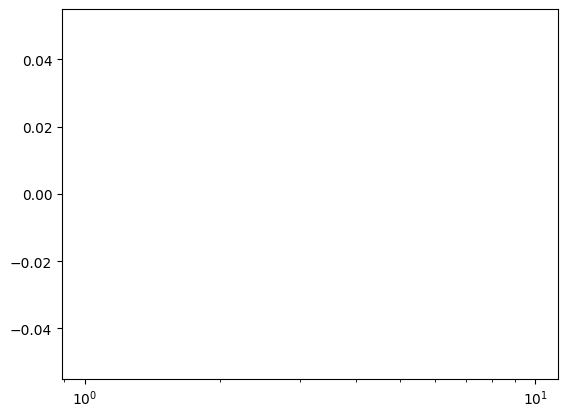

In [ ]:
opt = torch.optim.AdamW
cbs = [LLMMetricsCB(accuracy=MulticlassAccuracy()), ProgressCB(), DeviceCB(), MixedPrecision()]
learn = Learner(model, out_batches, loss_func=loss_fn, cbs=cbs, opt_func=opt)
learn.lr_find()

In [ ]:
from functools import partial
from torch.optim import lr_scheduler

In [ ]:
lr, epochs = 1e-4, 2
tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
xtra = [BatchSchedCB(sched)]

GLU for ff

accuracy,loss,epoch,train,time
0.436,2.730,0,train,1:02:21
0.568,1.761,0,eval,00:10
0.596,1.605,1,train,1:06:52
0.599,1.592,1,eval,00:01


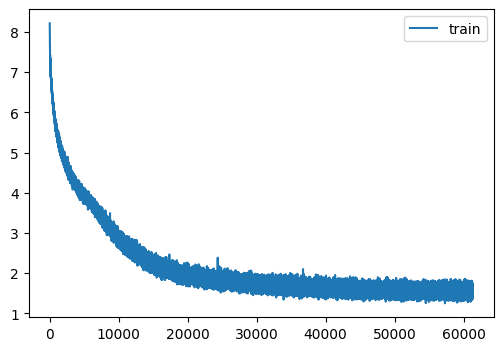

In [ ]:
set_seed(42)
model = torch.compile(GPTModel(cfg).to(def_device), mode="reduce-overhead")
cbs = [LLMMetricsCB(accuracy=MulticlassAccuracy()), ProgressCB(plot=True), DeviceCB(), MixedPrecision()]
learn = Learner(model, dls, loss_func=loss_fn, cbs=cbs+xtra, opt_func=opt)
learn.fit(epochs, lr=lr)

In [ ]:
start_context = "Once upon a time, there lived a bunny in a field. Her name was Lucy. Lucy loved to have feasts and parties with her bunny friends. One day, when Lucy was about to leave for a feast at a friend's house, she realized she's starting to feel sick. She was so weak she could"
model.eval()
token_ids = generate(
    model=model.eval(),
    idx=text_to_token_ids("Once upon a time, there lived a bunny in a field. Her name was Lucy. Lucy loved to have feasts and parties with her bunny friends. One day, when Lucy was about to leave for a feast at a friend's house, she realized she's starting to feel sick. She was so weak she could", tokenizer).to(def_device),
    max_new_tokens=180,
    context_size=cfg["ctx_len"],
    top_k=25,
    temperature=1.1
)

print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 Once upon a time, there lived a bunny in a field. Her name was Lucy. Lucy loved to have feasts and parties with her bunny friends. One day, when Lucy was about to leave for a feast at a friend's house, she realized she's starting to feel sick. She was so weak she could not run or get enough food, so she couldn't even call for help!

Lucy was so sad she didn't feel like when it was getting late. She regretted not getting to see the festival. Eventually, it was time to go to the festival. Lucy was sad that she had to leave.

Then, Lucy had an idea. She decided to take a special nap under her favourite dress and put it in her dresser. After that, when she saw the festival, she realized that she had been weak for a moment. But, it made her feel better. She was relieved to see that all the way to the festival had paid off, but she learned that it must be okay to have an even worthier way. 

Lucy was happy and excited to have re


In [ ]:
import pandas as pd

In [ ]:
df = pd.read_csv('evaluation_prompts.csv')
df.head()

,prompt,completion
0,"Once upon a time, there lived a bunny in a fie...",NaN
1,"Once upon a time, there lived a bunny in a fie...",NaN
2,"Once upon a time, there lived a bunny in a fie...",NaN
3,"Once upon a time, there lived a bunny in a fie...",NaN
4,"Once upon a time, there lived a bunny in a fie...",NaN


In [ ]:
def process_row(row, model, tokenizer, max_tokens=180, context_size=cfg["ctx_len"], 
                top_k=25, temperature=1.3):
    # Tokenize the prompt
    toks = text_to_token_ids(row['prompt'], tokenizer)
    
    # Generate completion
    token_ids = generate(
        model=model,
        idx=toks.to(def_device),
        max_new_tokens=max_tokens,
        context_size=context_size,
        top_k=top_k,
        temperature=temperature
    )
    
    # Extract only the generated part (not the original prompt)
    completion = token_ids_to_text(token_ids[:, toks.shape[1]:], tokenizer)
    
    return completion

# Apply the function to each row in the dataframe
df['completion'] = df.apply(lambda row: process_row(row, model, tokenizer), axis=1)

In [ ]:
df.head()

,prompt,completion
0,"Once upon a time, there lived a bunny in a fie...",not move.\n\nLucy saw that Lucy was tired and...
1,"Once upon a time, there lived a bunny in a fie...","not breathe.\n\nLuckily, Lucy heard a loud ye..."
2,"Once upon a time, there lived a bunny in a fie...",not find her way back home. Lucy's mommy was ...
3,"Once upon a time, there lived a bunny in a fie...",barely breathe again!\n\nLucy knew her friend...
4,"Once upon a time, there lived a bunny in a fie...","hard out.\n\nAt home, Lucy's mom gave her a w..."


In [ ]:
df.to_csv("0401_init.csv", index=False)

In [ ]:
pd.read_csv("0401_init.csv").head()

,prompt,completion
0,"Once upon a time, there lived a bunny in a fie...",not move.\n\nLucy saw that Lucy was tired and...
1,"Once upon a time, there lived a bunny in a fie...","not breathe.\n\nLuckily, Lucy heard a loud ye..."
2,"Once upon a time, there lived a bunny in a fie...",not find her way back home. Lucy's mommy was ...
3,"Once upon a time, there lived a bunny in a fie...",barely breathe again!\n\nLucy knew her friend...
4,"Once upon a time, there lived a bunny in a fie...","hard out.\n\nAt home, Lucy's mom gave her a w..."


Hyperparameters: Learning rate, optimizer: Gradient clipping, batch size: 4k

Mixed precision -> weight decay needed. (bfloat16)

Distributed data parallel: Split data into 2 and use graident accumulation

Fully Sharded data parallel: shard of data into GPUs as layer goes.

CPU offload

DataLoader: Use for loop.

!!!!! Look at the data. !!!!!

Eval: next token accuracy, loss

Try GLU instead of ReLU

Tips: 

1. Try simple model.
2. Weight Tying.
3. Hyperparameter sweep
4. minbpe


Get sequencing packing to work -> iterate faster
flash attention.

Use triton cross entropy loss or compile nn.crosstropyloss

Add view(-1,...) before flash attention and remove view(-1,...)